In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
from PIL import Image
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_curve
from tqdm import tqdm

import time

In [4]:
# Keras & Tensorflow
import keras
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.layers import Lambda, concatenate
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D , Conv2D , MaxPooling2D
from keras.layers import  Dropout , BatchNormalization , Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy

In [5]:
benign_train = np.load('/content/drive/MyDrive/CSE499/numpy/benign_train.npy')
malign_train = np.load('/content/drive/MyDrive/CSE499/numpy/malign_train.npy')
benign_test = np.load('/content/drive/MyDrive/CSE499/numpy/benign_test.npy')
malign_test = np.load('/content/drive/MyDrive/CSE499/numpy/malign_test.npy')
print('Done Loaded :)')

Done Loaded :)


In [6]:
#Shape of our dataset
print(f'Benign Train:',benign_train.shape)
print(f'Malignant Train',malign_train.shape)
print(f'Benign Test:',benign_test.shape)
print(f'Malignant Test',malign_test.shape)

Benign Train: (3500, 224, 224, 3)
Malignant Train (3496, 224, 224, 3)
Benign Test: (1500, 224, 224, 3)
Malignant Test (1500, 224, 224, 3)


In [7]:
benign_train_label = np.zeros(len(benign_train),dtype=float)
malign_train_label = np.ones(len(malign_train),dtype=float)
benign_test_label = np.zeros(len(benign_test),dtype=float)
malign_test_label = np.ones(len(malign_test),dtype=float) 

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [8]:
print(f'X train shape:',X_train.shape)
print(f'X test shape:',X_test.shape)
print(f'Y train shape:',Y_train.shape)
print(f'Y test shape:',Y_test.shape)

X train shape: (6996, 224, 224, 3)
X test shape: (3000, 224, 224, 3)
Y train shape: (6996, 2)
Y test shape: (3000, 2)


In [9]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=10)

In [10]:
print(f'x train shape:',x_train.shape)
print(f'x val shape:',x_val.shape)
print(f'y train shape:',y_train.shape)
print(f'y val shape:',y_val.shape)

x train shape: (5596, 224, 224, 3)
x val shape: (1400, 224, 224, 3)
y train shape: (5596, 2)
y val shape: (1400, 2)


In [11]:
# MobileNet
from tensorflow.keras.applications import MobileNet

def mobile_model1(backbone , lr = 1e-4):
  model1 = Sequential()
  model1.add(backbone)
  model1.add(layers.GlobalAveragePooling2D())
  model1.add(layers.Dropout(0.5))
  model1.add(layers.BatchNormalization())
  model1.add(layers.Dense(2 , activation='softmax'))
  
  model1.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    
  return model1


mobilenet1 = MobileNet(
    weights = 'imagenet',
    include_top = False,
    input_shape =(224 , 224 , 3)
)
#call the model 
model1 = mobile_model1(mobilenet1 , lr = 1e-4)
model1.build((None, 224, 224, 3))
model1.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 20

In [12]:
# Training the teacher model with Resnet50
# Train the teacher model as usual
epochs = 20
batch_size = 64
teacher_his = model1.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/20
88/88 [==============================] - 95s 686ms/step - loss: 0.2264 - accuracy: 0.9216 - val_loss: 0.1817 - val_accuracy: 0.9207
Epoch 2/20
88/88 [==============================] - 58s 654ms/step - loss: 0.0909 - accuracy: 0.9650 - val_loss: 0.1244 - val_accuracy: 0.9464
Epoch 3/20
88/88 [==============================] - 58s 655ms/step - loss: 0.0487 - accuracy: 0.9809 - val_loss: 0.1221 - val_accuracy: 0.9486
Epoch 4/20
88/88 [==============================] - 58s 655ms/step - loss: 0.0296 - accuracy: 0.9887 - val_loss: 0.1366 - val_accuracy: 0.9471
Epoch 5/20
88/88 [==============================] - 58s 656ms/step - loss: 0.0139 - accuracy: 0.9962 - val_loss: 0.1495 - val_accuracy: 0.9500
Epoch 6/20
88/88 [==============================] - 58s 657ms/step - loss: 0.0102 - accuracy: 0.9973 - val_loss: 0.1331 - val_accuracy: 0.9621
Epoch 7/20
88/88 [==============================] - 58s 657ms/step - loss: 0.0051 - accuracy: 0.9986 - val_loss: 0.1466 - val_accuracy: 0.9514

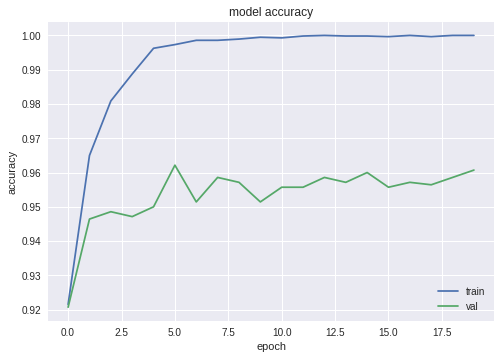

In [13]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['accuracy'],)
plt.plot(teacher_his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

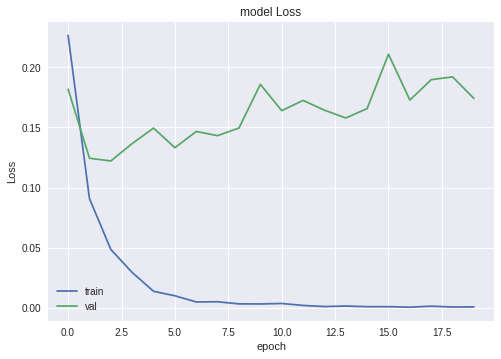

In [14]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['loss'])
plt.plot(teacher_his.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

In [15]:
Y_val_pred = model1.predict(x_val)
print(f'The Teacher model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1)))

The Teacher model Accuracy on the Validation Set: 0.9607142857142857


In [16]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [17]:
#Now let's check my predcited values from X_test dataset	
# And calculate the y_pred with time
import timeit

start = timeit.default_timer()
#Your statements here
y_pred = model1.predict(X_test)
print(f'My predicted Y_test values are:\n' ,y_pred)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My predicted Y_test values are:
 [[9.9999344e-01 6.5030322e-06]
 [3.7375928e-04 9.9962628e-01]
 [1.4851315e-06 9.9999857e-01]
 ...
 [9.9999285e-01 7.1897166e-06]
 [2.6187649e-07 9.9999976e-01]
 [1.9846143e-08 1.0000000e+00]]

Time:  6.812424214999737 sec


In [18]:
#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy:',accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

My accuracy: 0.993


In [19]:
# Print the classification report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1500
           1       1.00      0.99      0.99      1500

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [20]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1),pos_label=1)

# roc curve for
random_probs = [0 for i in range(len(np.argmax(Y_test, axis=1)))]
p_fpr, p_tpr, _ = roc_curve(np.argmax(Y_test, axis=1), random_probs, pos_label=1)

# auc scores
from sklearn.metrics import roc_auc_score
auc_score1 = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
print(auc_score1)

0.9930000000000001


No handles with labels found to put in legend.


0.9930000000000001


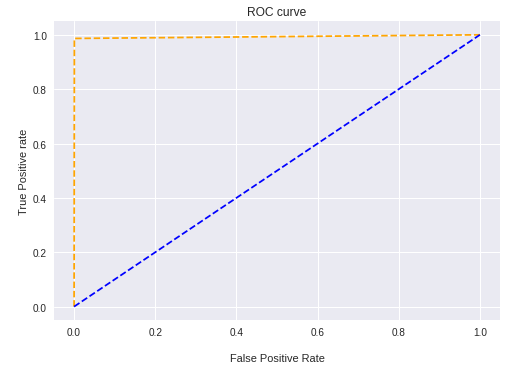

In [21]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1),pos_label=1)

# roc curve for
random_probs = [0 for i in range(len(np.argmax(Y_test, axis=1)))]
p_fpr, p_tpr, _ = roc_curve(np.argmax(Y_test, axis=1), random_probs, pos_label=1)

# auc scores
auc_score1 = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
print(auc_score1)


# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('\nFalse Positive Rate')
# y label
plt.ylabel('\nTrue Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();